In [27]:
# JSS
## TODO 
#using pca to reduce the dimensionality of the global descriptors
#using MobileVnet instead of netVLAD
#using hfnet instead of netVlAD and MobileVnet --that is not working 
# this will also help reduce the complexity 
#understand what superglue is outputting
# getting two models from SFM 
# Setting up the scale of the model -- this is done easy and simple
import numpy as np
import argparse
import yaml
import logging
from pathlib import Path
from tqdm import tqdm
from pprint import pformat
import h5py
import json
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
# from notebooks.utils import plot_images, plot_matches, add_frame
from hfnet.models import get_model  
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '7'
# send the path to the image directory and get the path to all the images in it
def image_directory_parser(path, viewer=True, number= 4):    
    globs=['*.jpg', '*.png', '*.jpeg', '*.JPG', '*.PNG']
    ## can also use sufix instead of with method
    image_path = []
    for g in globs:
        image_path += list(path.glob("**/"+g))
    print(len(image_path))
    if viewer:
        nrows = number
        ncols = number
        fig = plt.gcf()
        fig.set_size_inches(ncols*4, ncols*4)
        for i in range(2*number):
            sp = plt.subplot(nrows, ncols, i + 1)
            sp.axis('Off') # Don't show axes (or gridlines)
            img = mpimg.imread((image_path[i]))
            plt.imshow(img)
        plt.show()
    return image_path


In [28]:
path_to_images_for_map = Path('/home/Hierarchical-Localization/datasets/ipadT4images')

1117


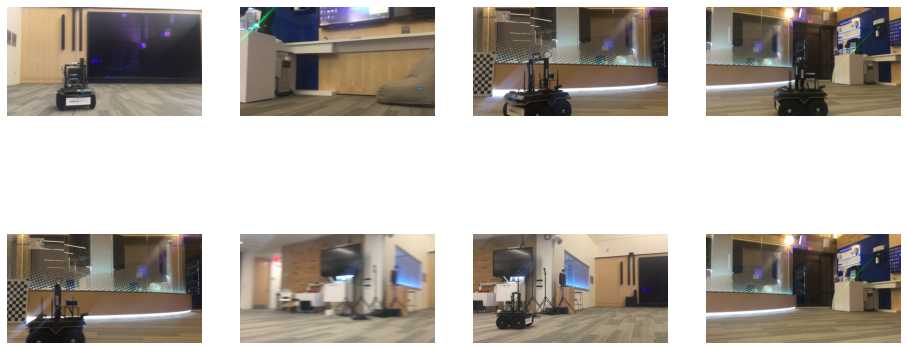

In [29]:
image_path = image_directory_parser(path_to_images_for_map, viewer=True, number = 4) 

In [31]:
def dictionary_of_images(image_path):
    image_dict ={}
    for i,j in tqdm(enumerate(image_path)):
        image_array = cv2.imread(str(j))
#         print(image_path[i].name)
        image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
        image_dict[i] = {"image":image_array, "name": image_path[i].name, "number": i}
    return image_dict

In [32]:
image_dict = dictionary_of_images(image_path)
print(len(image_dict))

1117it [00:10, 110.93it/s]

1117


In [3]:
output_path = Path("/home/Hierarchical-Localization/outputs/ipadT4HFnet")
# output_path.mkdir()

In [7]:
#jss
import argparse
import logging
from pathlib import Path
import h5py
import numpy as np
import torch
import json
import cv2
import numpy as np
from pathlib import Path
from hfnet.settings import EXPER_PATH
# from notebooks.utils import plot_images, plot_matches, add_frame

import tensorflow as tf
from tensorflow.python.saved_model import tag_constants
tf.contrib.resampler  # import C++ op

%load_ext autoreload
%autoreload 2
%matplotlib inline

W0222 09:29:47.750936 140622273476416 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [8]:
class HFNet:
    def __init__(self, model_path, outputs):
        self.session = tf.Session()
        self.image_ph = tf.placeholder(tf.float32, shape=(None, None, 3))

        net_input = tf.image.rgb_to_grayscale(self.image_ph[None])
        tf.saved_model.loader.load(
            self.session, [tag_constants.SERVING], str(model_path),
            clear_devices=True,
            input_map={'image:0': net_input})

        graph = tf.get_default_graph()
        self.outputs = {n: graph.get_tensor_by_name(n+':0')[0] for n in outputs}
        self.nms_radius_op = graph.get_tensor_by_name('pred/simple_nms/radius:0')
        self.num_keypoints_op = graph.get_tensor_by_name('pred/top_k_keypoints/k:0')

    def inference(self, image, nms_radius=4, num_keypoints=1000):
        inputs = {
            self.image_ph: image[..., ::-1].astype(np.float),
            self.nms_radius_op: nms_radius,
            self.num_keypoints_op: num_keypoints,
        }
        return self.session.run(self.outputs, feed_dict=inputs)

In [9]:
model_path = Path("/home/Hierarchical-Localization/hfnet/model/saved_models/hfnet")

outputs = ['global_descriptor', 'keypoints', 'local_descriptors', 'scores']
hfnet = HFNet(model_path, outputs)

W0222 09:30:00.958044 140622273476416 deprecation.py:323] From <ipython-input-8-8a62a65d9558>:10: load (from tensorflow.python.saved_model.loader_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
W0222 09:30:01.646018 140622273476416 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
I0222 09:30:01.648309 140622273476416 saver.py:1280] Restoring parameters from /home/Hierarchical-Localization/hfnet/model/saved_models/hfnet/variables/variables


In [10]:
global_feature_path = output_path/"global_features.h5"
local_feature_path = output_path/"local_feature.h5"
global_feature_file = h5py.File(str(global_feature_path), 'w')
local_feature_file = h5py.File(str(local_feature_path), 'w')
global_feature_dict = {}
for i in tqdm(range(len(image_dict))):
    image = (image_dict[i]["image"]).astype(float)
#     print(image.shape)
    name = image_dict[i]["name"]
    db = hfnet.inference(image)
    grp = global_feature_file.create_group(str(name))
    grp.create_dataset('global_descriptor', data=db['global_descriptor'])
    if i == 0:
        global_matrix = np.array(db['global_descriptor'])
    else:
        global_matrix = np.vstack((global_matrix,db['global_descriptor'])) 
    global_feature_dict[i] = {"global_descriptor":db['global_descriptor'], "name":name}
    grp = local_feature_file.create_group(str(name))
    size = np.array(image.shape[:2][::-1])
#     print(size)
    grp.create_dataset('keypoints', data=db['keypoints'])
    grp.create_dataset('descriptors', data=np.transpose(db['local_descriptors']))
    grp.create_dataset('scores', data=db['scores'])
    grp.create_dataset('image_size', data= size)
    
global_feature_file.close()
local_feature_file.close()

100%|██████████| 1117/1117 [00:29<00:00, 38.36it/s]


In [11]:
np.shape(global_matrix)

(1117, 4096)

In [12]:
def compute_distance(desc1, desc2):
    # For normalized descriptors, computing the distance is a simple matrix multiplication.
    return 2 * (1 - desc1 @ desc2.T)
## needs both global matrix and dict as we need to give names too
## I am idiot if I keep wiritng codes like this one lol ;)
# Need to change it hehehe
# Writing the .txt file.
def text_file_for_global_matches(global_feature_dict, global_feature_matrix, path, number): 
    predictions_dict_matches = {}
    for i in tqdm(range(len(global_feature_dict))):
        current_descriptor = global_feature_matrix[i, :]
        neighbours = compute_distance(current_descriptor, global_feature_matrix)
        predictions_dict_matches[i] = ((np.argsort(neighbours))[:number])[1 :]
    #first writing the file
    output_file_txt = path/"global_feature.txt"
    with open(output_file_txt, 'w') as f:
        for i in tqdm(range(len(predictions_dict_matches))):
            current_image_name = global_feature_dict[i]["name"]
            current_image_matches = predictions_dict_matches[i]
            string_list = []
            for j in range(len(current_image_matches)):
                    if i == 0 and j ==0:
                        making_a_string = current_image_name + " " + global_feature_dict[current_image_matches[j]]["name"]
                    
                    else: 
                        making_a_string = "\n" + current_image_name + " " + global_feature_dict[current_image_matches[j]]["name"]
                    f.write(making_a_string)  
    ## checking common lines and rewriting
    image_list_for_finding_common_separated = []
    with open(output_file_txt, 'r') as f:
        image_list_for_finding_common = [l.strip() for l in f]
    for i in range(len(image_list_for_finding_common)):
        current_index_value = image_list_for_finding_common[i]
        current_index_value = list(current_index_value.split(" "))
        image_list_for_finding_common_separated.append(sorted(current_index_value))
    ilf = sorted(image_list_for_finding_common_separated)
    final_list = []
    for i in range(len(ilf)):
        if ilf[i] in final_list:
            pass
        else:
            final_list.append(ilf[i])
    with open(output_file_txt, 'w') as f:
        for i in range(len(final_list)):
            if i == 0:
                making_a_string = final_list[i][0]+ " " + final_list[i][1]
            else:
                making_a_string = "\n" + final_list[i][0]+ " " + final_list[i][1]
            f.write(making_a_string)

In [13]:
text_file_for_global_matches(global_feature_dict, global_matrix,output_path,5)

100%|██████████| 1117/1117 [00:00<00:00, 61890.35it/s]


In [4]:
### Bringing in HLOC
%load_ext autoreload
%autoreload 2
from hloc import extract_features, match_features, reconstruction, visualization
feature_conf_superpoint = {'output': 'local_feature', 'model': {'name': 'superpoint', 'nms_radius': 3, 'max_keypoints': 4096}, 'preprocessing': {'grayscale': True, 'resize_max': 960}}
# os.environ["CUDA_VISIBLE_DEVICES"] = '5'


In [5]:
matcher_conf = {'output': 'matches-superglue', 'model': {'name': 'superglue', 'weights': 'outdoor', 'sinkhorn_iterations': 50}}
features = feature_conf_superpoint['output']
sfm_pairs = output_path/"global_feature.txt"

In [6]:
match_features.main(matcher_conf, sfm_pairs, features, output_path)

[02/22/2021 09:31:41 INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


Loaded SuperGlue model ("outdoor" weights)


100%|██████████| 2910/2910 [02:38<00:00, 18.34it/s]
[02/22/2021 09:34:24 INFO] Finished exporting matches.


In [7]:
sfm_dir = output_path/'sfm_superpoint+superglue'
feature_file = output_path/'local_feature.h5'
match_file = output_path/'local_feature_matches-superglue_global_feature.h5'

In [8]:
reconstruction.main(
    sfm_dir,
    path_to_images_for_map,
    sfm_pairs,
    feature_file,
    match_file)

[02/22/2021 09:34:24 INFO] Creating an empty database...
[02/22/2021 09:34:24 INFO] Importing images into the database...
[02/22/2021 09:34:35 INFO] Importing features into the database...
100%|██████████| 1117/1117 [00:00<00:00, 2841.62it/s]
[02/22/2021 09:34:35 INFO] Importing matches into the database...
100%|██████████| 2910/2910 [00:01<00:00, 2352.93it/s]
[02/22/2021 09:34:36 INFO] Performing geometric verification of the matches...
[02/22/2021 09:34:38 INFO] Running the 3D reconstruction...
[02/22/2021 09:34:38 INFO] colmap mapper --database_path /home/Hierarchical-Localization/outputs/ipadT4HFnet/sfm_superpoint+superglue/database.db --image_path /home/Hierarchical-Localization/datasets/ipadT4images --output_path /home/Hierarchical-Localization/outputs/ipadT4HFnet/sfm_superpoint+superglue/models
[02/22/2021 11:09:55 INFO] Reconstructed 1 models.
[02/22/2021 11:09:55 INFO] Largest model is #0 with {largest_model_num_images} images.
[02/22/2021 11:09:55 INFO] Statistics:
{'mean_rep

In [9]:
## find the error within itself
import os
import sys
import collections
import numpy as np
import struct
import argparse
BaseImage = collections.namedtuple(
    "Image", ["id", "qvec", "tvec", "camera_id", "name", "xys", "point3D_ids"])
class Image(BaseImage):
    def qvec2rotmat(self):
        return qvec2rotmat(self.qvec)
def read_images_binary(path_to_model_file):
    """
    see: src/base/reconstruction.cc
        void Reconstruction::ReadImagesBinary(const std::string& path)
        void Reconstruction::WriteImagesBinary(const std::string& path)
    """
    images = {}
    with open(path_to_model_file, "rb") as fid:
        num_reg_images = read_next_bytes(fid, 8, "Q")[0]
        for image_index in range(num_reg_images):
            binary_image_properties = read_next_bytes(
                fid, num_bytes=64, format_char_sequence="idddddddi")
            image_id = binary_image_properties[0]
            qvec = np.array(binary_image_properties[1:5])
            tvec = np.array(binary_image_properties[5:8])
            camera_id = binary_image_properties[8]
            image_name = ""
            current_char = read_next_bytes(fid, 1, "c")[0]
            while current_char != b"\x00":   # look for the ASCII 0 entry
                image_name += current_char.decode("utf-8")
                current_char = read_next_bytes(fid, 1, "c")[0]
            num_points2D = read_next_bytes(fid, num_bytes=8,
                                           format_char_sequence="Q")[0]
            x_y_id_s = read_next_bytes(fid, num_bytes=24*num_points2D,
                                       format_char_sequence="ddq"*num_points2D)
            xys = np.column_stack([tuple(map(float, x_y_id_s[0::3])),
                                   tuple(map(float, x_y_id_s[1::3]))])
            point3D_ids = np.array(tuple(map(int, x_y_id_s[2::3])))
            images[image_name] = Image(
                id=image_id, qvec=qvec, tvec=tvec,
                camera_id=camera_id, name=image_name,
                xys=xys, point3D_ids=point3D_ids)
    return images
def read_next_bytes(fid, num_bytes, format_char_sequence, endian_character="<"):
    """Read and unpack the next bytes from a binary file.
    :param fid:
    :param num_bytes: Sum of combination of {2, 4, 8}, e.g. 2, 6, 16, 30, etc.
    :param format_char_sequence: List of {c, e, f, d, h, H, i, I, l, L, q, Q}.
    :param endian_character: Any of {@, =, <, >, !}
    :return: Tuple of read and unpacked values.
    """
    data = fid.read(num_bytes)
    return struct.unpack(endian_character + format_char_sequence, data)

In [12]:
image_bin_path = sfm_dir/"models/0/images.bin"

In [13]:
ReadImagesBinary = read_images_binary(image_bin_path) ###not required now


In [59]:
def dictionary_of_images_name(image_path):
    image_dict ={}
    for i,j in tqdm(enumerate(image_path)):
        image_array = cv2.imread(str(j))
#         print(image_path[i].name)
        image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
        image_dict[image_path[i].name] = {"image":image_array}
    return image_dict

In [60]:
dict_image_name = dictionary_of_images_name(image_path)

1117it [00:10, 106.07it/s]


In [76]:
def points_tracked(read_binary, image_name, image_dict):
    list_of_names_binary = list(read_binary.keys())
    if image_name not in list_of_names_binary:
        print("Image is not registered")
        return 
    keypoints_reduced = read_binary[image_name][-2] - 0.5
    points_id = read_binary[image_name][-1]
    points_tracked = keypoints_reduced[np.where(points_id!=-1)]
    points_not_tracked = keypoints_reduced[np.where(points_id==-1)]
    plot_images([image_dict[image_name]['image']])
    plot_keypoints([points_tracked], ps= 10)
    plot_keypoints([points_not_tracked], ps=10, colors="red")

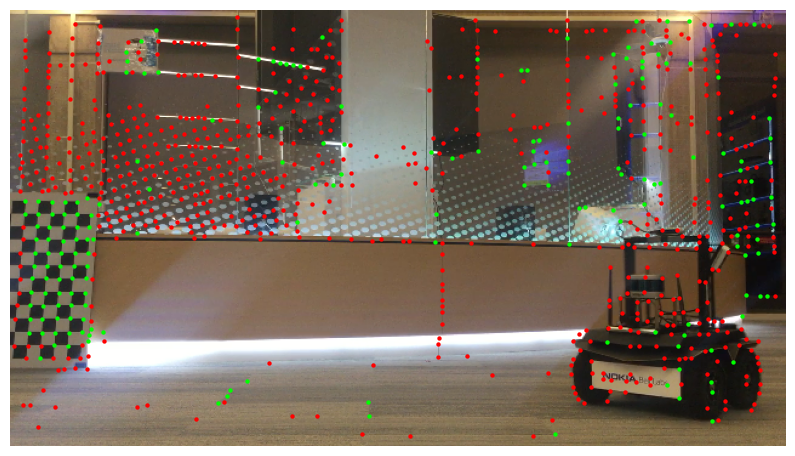

In [119]:
points_tracked(ReadImagesBinary,'iPadT4_212_419-06370.png',dict_image_name )

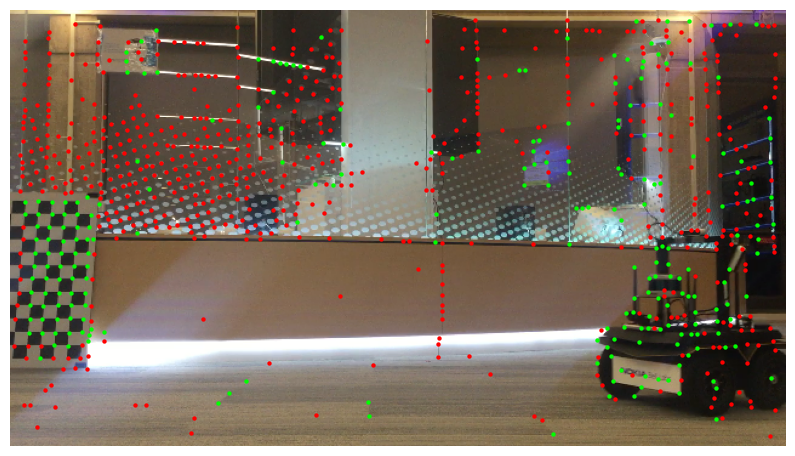

In [120]:
points_tracked(ReadImagesBinary,'iPadT4_212_086-06360.png',dict_image_name )

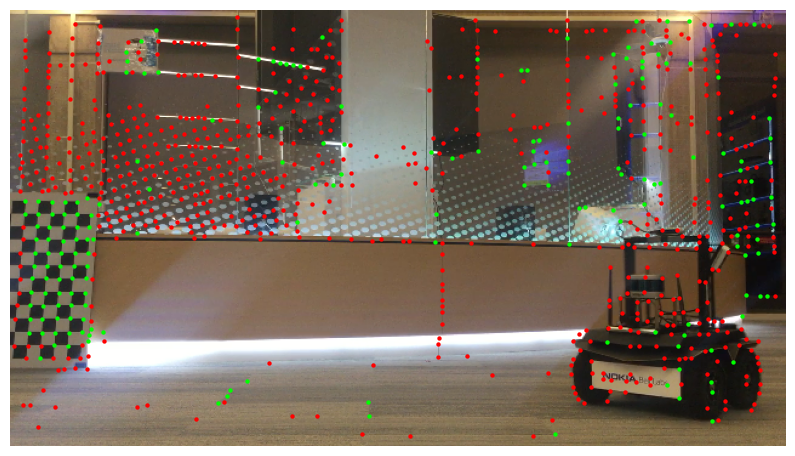

In [121]:
points_tracked(ReadImagesBinary,'iPadT4_212_419-06370.png',dict_image_name )

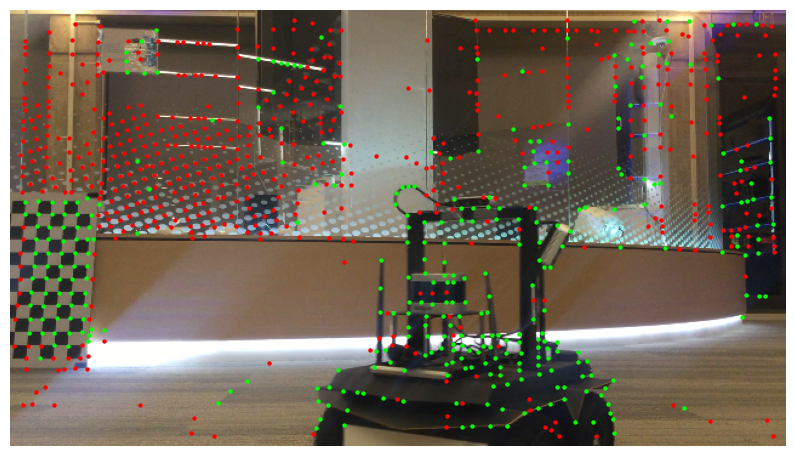

In [122]:
points_tracked(ReadImagesBinary,'iPadT4_215_754-06470.png',dict_image_name )

In [123]:
points_tracked(ReadImagesBinary,'iPadT4_212_088-06480.png',dict_image_name )

Image is not registered


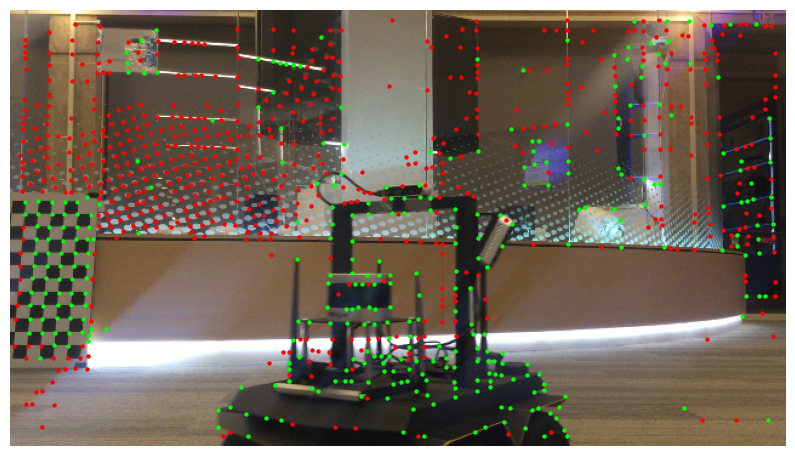

In [125]:
points_tracked(ReadImagesBinary,'iPadT4_216_421-06490.png',dict_image_name )

In [ ]:
visualization.visualize_loc(
    results, images, reference_sfm / 'model', n=1, top_k_db=1, prefix='query/night', seed=2)

In [126]:
results = Path("/home/Hierarchical-Localization/outputs/sfm_T5_skip_9/Image_added_0.35_masked/Image_added_scale_0.35_masked_T3results.txt")

In [128]:
import pickle
with open(str(results)+'_logs.pkl', 'rb') as f:
    logs = pickle.load(f)

In [134]:
queries = list(logs['loc'].keys())

In [136]:
import random
seed = 0
selected = random.Random(seed).sample(queries, 1)
print(selected)

['iPhoSilWithWv3_1598592761_507-14520.png']


In [141]:
loc = logs['loc']['iPhoSilWithWv3_1598592761_507-14520.png']

In [143]:
inliers = np.array(loc['PnP_ret']['inliers'])
mkp_q = loc['keypoints_query']
n = len(loc['db'])

In [144]:
inliers


array([ True,  True,  True, ...,  True,  True, False])

In [145]:
mkp_q

array([[ 77.5,   8.5],
       [184.5,   8.5],
       [208.5,   8.5],
       ...,
       [324.5, 239.5],
       [199.5, 263.5],
       [106.5, 318.5]], dtype=float32)

In [146]:
n

10

In [147]:
logs['loc']['iPhoSilWithWv3_1598592761_507-14520.png']

{'db': [14393, 14368, 15039, 17339, 14403, 17355, 15079, 15089, 19732, 12228],
 'PnP_ret': {'success': True,
  'qvec': array([-0.09376268, -0.15867061,  0.71527991, -0.67409706]),
  'tvec': array([-1.23741112,  1.08721991, -2.76772334]),
  'num_inliers': 1127,
  'inliers': [True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   False,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True,
   True

In [148]:
# 'params': array([6.58503e+02, 3.20000e+02, 1.80000e+02, 5.65491e-02])